In [1]:
import os
import copy
import random
import time
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from fvcore.nn import FlopCountAnalysis


# =================================================================================
# 0. 재현성 / 유틸
# =================================================================================
def seed_everything(seed=42):
    """
    재현성 확보: Python, NumPy, PyTorch 모두 시드 고정
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def seed_worker(worker_id):
    """
    DataLoader의 worker마다 난수 고정
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [2]:
# =================================================================================
# 1. 데이터셋 (UCI-HAR)
# =================================================================================
from scipy import stats
from sklearn.model_selection import train_test_split # 추가

class WISDMDataset(Dataset):
    # __init__ 메서드를 파일 경로가 아닌 DataFrame을 받도록 수정
    def __init__(self, dataframe, window_size=200, step_size=20):
        self.window_size = window_size
        self.step_size = step_size
        self.activity_mapping = {
            'Walking': 0, 'Jogging': 1, 'Upstairs': 2,
            'Downstairs': 3, 'Sitting': 4, 'Standing': 5
        }
        
        # 이제 외부에서 전달받은 DataFrame으로 바로 윈도우를 분할합니다.
        self.X, self.y = self._segment_data(dataframe)
        
        print(f"Dataset created with X shape={self.X.shape}, y shape={self.y.shape}")

    def _segment_data(self, df):
        """데이터를 슬라이딩 윈도우 방식으로 분할합니다."""
        signals, labels = [], []
        
        # 사용자별, 활동별로 데이터를 그룹화
        for (user, activity), group in df.groupby(['user', 'activity']):
            for i in range(0, len(group) - self.window_size, self.step_size):
                window = group.iloc[i : i + self.window_size]
                
                signals.append(window[['x', 'y', 'z']].values.T) # (3, window_size) 형태로 바로 변환
                labels.append(self.activity_mapping[activity])

        return np.array(signals, dtype=np.float32), np.array(labels, dtype=np.int32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.LongTensor([self.y[idx]])[0]

# --- load_full_dataframe 함수 추가 ---
def load_full_dataframe(filepath):
    """오류 처리를 포함하여 전체 raw txt 파일을 로드하는 함수"""
    col_names = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
    df = pd.read_csv(filepath, header=None, names=col_names, on_bad_lines='skip')
    df['z'] = pd.to_numeric(df['z'].astype(str).str.rstrip(';'), errors='coerce')
    df.dropna(axis=0, how='any', inplace=True)
    return df

In [3]:
# =================================================================================
# 2. CBAM (1D 버전)
# =================================================================================
class ChannelAttention1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = self.avg_pool(x).squeeze(-1)  # (B, C)
        max_out = self.max_pool(x).squeeze(-1)  # (B, C)

        avg_out = self.fc(avg_out)
        max_out = self.fc(max_out)

        out = (avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        scale = self.sigmoid(out)
        return x * scale


class TemporalAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x : (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, T)

        out = torch.cat([avg_out, max_out], dim=1)  # (B, 2, T)
        out = self.conv(out)                        # (B, 1, T)
        out = self.sigmoid(out)
        return x * out


class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention1D(channels, reduction)
        self.temporal_att = TemporalAttention1D(kernel_size)

    def forward(self, x):
        # x : (B, C, T)
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x

In [4]:
# =================================================================================
# 3. Contrastive Prototype Loss
# =================================================================================
class ContrastivePrototypeLoss(nn.Module):
    """
    각 클래스의 prototype과 feature를 InfoNCE 방식으로 밀어붙이는 loss
    """
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, prototypes, labels):
        """
        Contrastive Loss between features and prototypes

        Args:
            features: (B, D) - 샘플 특징
            prototypes: (N_class, D) - 클래스별 프로토타입
            labels: (B,) - 레이블

        Returns:
            loss: contrastive loss
        """
        # L2 normalize
        features = F.normalize(features, dim=1)
        prototypes = F.normalize(prototypes, dim=1)

        # cosine similarity
        logits = torch.matmul(features, prototypes.t()) / self.temperature  # (B, num_classes)

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)
        return loss

In [5]:
# =================================================================================
# 4. CrossFormer Block (Cross-Attn between tokens and learnable prototypes)
# =================================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self,
                 dim,
                 n_prototypes=6,
                 n_heads=4,
                 mlp_ratio=2.0, 
                 dropout=0.1,
                 initial_prototypes=None):
        super().__init__()
        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))
        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, \
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} vs self.prototypes {self.prototypes.shape}"
            self.prototypes.data.copy_(initial_prototypes)
            print(">>> [Main Model] Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print(">>> [Temporary Model or No Init Provided] Prototypes initialized with Xavier Uniform.")

        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(dim, hidden_dim), nn.GELU(), nn.Dropout(dropout),
                                 nn.Linear(hidden_dim, dim), nn.Dropout(dropout))
        self.proto_proj = nn.Sequential(nn.Linear(dim, dim), nn.GELU(), nn.Linear(dim, dim))

    def forward(self, x, return_proto_features=False, skip_cross_attention=False):
        B, T, C = x.shape
        attn_weights = None

        if not skip_cross_attention:
            normalized_prototypes = F.normalize(self.prototypes, dim=1)
            prototypes = normalized_prototypes.unsqueeze(0).expand(B, -1, -1)
            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
            x = x + cross_out

        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out
        x = x + self.mlp(self.norm3(x))

        if return_proto_features:
            proto_features = x.mean(dim=1)
            proto_features = self.proto_proj(proto_features)
            return x, proto_features, attn_weights
        
        return x

In [6]:
# =================================================================================
# 5. 최종 HAR 모델: embedding + (CBAM) + CrossFormer + classifier
# =================================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    def __init__(self,
                 in_channels=9, 
                 seq_len=128,
                 embed_dim=64, 
                 reduced_dim=32,
                 n_classes=6, 
                 n_prototypes=6, 
                 n_heads=8,
                 kernel_size=7,
                 dropout=0.1,
                 temperature=0.07, 
                 initial_prototypes=None,
                 use_cbam=True,
                 use_crossformer=True,
                 use_contrast=True,
                 use_dim_reduction=False):
        super().__init__()
        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        self.embedding = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(embed_dim), nn.GELU(), nn.Dropout(dropout)
        )

        if self.use_cbam:
            self.cbam = CBAM1D(embed_dim, reduction=8, kernel_size=kernel_size)

        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim, n_prototypes=n_prototypes, n_heads=n_heads,
                mlp_ratio=2.0, dropout=dropout, initial_prototypes=initial_prototypes
            )
        else:
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim, nhead=n_heads, dim_feedforward=int(working_dim * 2),
                dropout=dropout, batch_first=True
            )

        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes)
        )
        
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=temperature)

    def forward(self, x, labels=None, return_contrast_loss=False):
        x = self.embedding(x)
        if self.use_cbam:
            x = self.cbam(x)
        x = x.transpose(1, 2).contiguous()
        if self.use_dim_reduction:
            x = self.dim_reduce(x)
        
        proto_features = None
        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, _ = self.crossformer(x, return_proto_features=True)
            else:
                x = self.crossformer(x, return_proto_features=False)
        else:
            x = self.self_attn(x)
            
        if self.use_dim_reduction:
            x = self.dim_restore(x)
            
        x = x.transpose(1, 2).contiguous()
        x = self.pool(x).squeeze(-1)
        logits = self.classifier(x)
        
        if return_contrast_loss and self.use_contrast and proto_features is not None and labels is not None:
            contrast_loss = self.contrast_loss(proto_features, self.crossformer.prototypes, labels)
            return logits, contrast_loss
        return logits

In [7]:
# =================================================================================
# 6. 프로토타입 초기화: train data 평균 feature로 클래스별 prototype 만들기
# =================================================================================
def get_mean_prototypes(train_full_dataset, device, config):
    print("Calculating initial prototypes from mean features...")

    temp_model = ContrastCrossFormerCBAM_HAR(
        in_channels=config['in_channels'],
        seq_len=config['seq_len'],
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'], 
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        use_cbam=True,
        use_crossformer=True, 
        use_contrast=False,
        use_dim_reduction=config['use_dim_reduction']
    ).to(device)

    temp_model.eval()

    temp_loader = DataLoader(train_full_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=0)
    all_features, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device)
            x = temp_model.embedding(batch_x)
            if temp_model.use_cbam:
                x = temp_model.cbam(x)
            x = x.transpose(1, 2).contiguous()
            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)
            x = temp_model.crossformer(x, skip_cross_attention=True)
            x = x.transpose(1, 2).contiguous()
            pooled_features = temp_model.pool(x).squeeze(-1)
            all_features.append(pooled_features.cpu())
            all_labels.append(batch_y.cpu())

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    working_dim = config['reduced_dim'] if config['use_dim_reduction'] else config['embed_dim']
    mean_prototypes = torch.zeros(temp_model.classifier[-1].out_features, working_dim)

    for i in range(len(mean_prototypes)):
        class_features = all_features[all_labels == i]
        if len(class_features) > 0:
            mean_prototypes[i] = class_features.mean(dim=0)
        else:
            mean_prototypes[i] = torch.randn(working_dim)

    print(f"Initial prototypes calculated. Shape: {mean_prototypes.shape}")
    
    return mean_prototypes.to(device)

In [8]:
# =================================================================================
# 7. 학습/평가 루프
# =================================================================================
def train_epoch(model, dataloader, criterion, optimizer, device, use_contrast=True, contrast_weight=0.5):
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_contrast_loss = 0
    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss + contrast_weight * contrast_loss
            total_contrast_loss += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    torch.cuda.synchronize() # 한 에폭 끝에서 동기화

    avg_loss = total_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)
    avg_contrast_loss = total_contrast_loss / len(dataloader) if total_contrast_loss > 0 else 0
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1, all_preds, all_labels

In [9]:
# =================================================================================
# 8. 시각화 + 리포트 (cm, t-SNE 등)
# =================================================================================

# 라벨 이름 (index 0~5가 이 순서라고 가정)
ACTIVITY_LABELS = [
    'Walking',
    'Jogging',
    'Upstairs',
    'Downstairs',
    'Sitting',
    'Standing'
]


def plot_classification_results(y_true, y_pred, save_path=None):
    """
    Confusion Matrix 시각화 (+ 선택적으로 파일 저장)
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=ACTIVITY_LABELS, digits=4))

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    print("\n" + "="*80)
    print("Normalized Confusion Matrix")
    print("="*80)
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=ACTIVITY_LABELS, yticklabels=ACTIVITY_LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] Confusion matrix → {save_path}")
    plt.show()
    plt.close()


def visualize_tsne(model, dataloader, device, save_path=None):
    """
    모델의 마지막 특징(분류 직전 표현)을 t-SNE로 2D 투영해서 그린다.
    """
    print("\n" + "="*80)
    print("Generating t-SNE visualization (MODEL FEATURE)...")
    print("="*80)

    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Extracting features for t-SNE"):
            xb = xb.to(device)

            # 모델 내부에서 classifier 직전 feature까지 따라가기
            # (아래 로직은 네 notebook의 visualize_tsne() 구조 복원)
            x = model.embedding(xb)
            if model.use_cbam:
                x = model.cbam(x)
            x = x.transpose(1, 2)
            if model.use_dim_reduction:
                x = model.dim_reduce(x)
            # backbone
            if model.use_crossformer:
                x = model.crossformer(
                    x,
                    return_proto_features=False,
                    skip_cross_attention=False
                )
            else:
                x = model.self_attn_layer(x)

            if model.use_dim_reduction:
                x = model.dim_restore(x)
            # GAP을 흉내내기 위한 mean pooling over seq
            pooled_features = x.mean(dim=1)  # (B, D_working)
            all_features.append(pooled_features.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=40,
        max_iter=4000,
        init='pca',
        learning_rate='auto'
    )
    proj = tsne.fit_transform(all_features)  # (N, 2)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [ACTIVITY_LABELS[l] for l in all_labels]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(ACTIVITY_LABELS)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE Visualization of Feature Space', fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(title='Activity', loc='upper right', fontsize=6, title_fontsize=7, labelspacing=0.2)
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] t-SNE (feature space) → {save_path}")

    plt.show()
    plt.close()


def visualize_tsne_raw(dataloader, device, save_path=None, max_points=2000):
    """
    모델을 거치기 전의 raw window (9채널 x 128길이)를
    그냥 flatten해서 t-SNE로 투영.
    """
    print("\n" + "="*80)
    print("Generating t-SNE visualization (RAW INPUT)...")
    print("="*80)

    all_raw = []
    all_labels = []

    for xb, yb in tqdm(dataloader, desc="Collecting raw windows for t-SNE"):
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)       # (N, C, T)
    all_labels = np.concatenate(all_labels, axis=0) # (N,)

    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]      # (M, C, T)
    y_sel = all_labels[idx]   # (M,)

    X_flat = X_sel.reshape(X_sel.shape[0], -1)  # (M, C*T)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=40,
        max_iter=4000,
        init='pca',
        learning_rate='auto'
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=['Dim1', 'Dim2'])
    df['label'] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(ACTIVITY_LABELS)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE Visualization of RAW Input Space', fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(title='Activity', loc='upper right', fontsize=6, title_fontsize=7, labelspacing=0.2)
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"[Saved] t-SNE (raw input) → {save_path}")

    plt.show()
    plt.close()

In [10]:
# =================================================================================
# 9. 모델 프로파일링: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model, sample_input, device, warmup=10, iters=50):
    """
    모델 구조/비용 측정:
    - 파라미터 수 (M)
    - FLOPs per sample (M)
    - 추론 시간 평균(ms)
    """
    model = model.to(device)
    model.eval()

    # params
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6

    # FLOPs
    with torch.no_grad():
        flops = FlopCountAnalysis(model, (sample_input.to(device),))
        flops_m = flops.total() / 1e6  # million FLOPs

    # inference time
    with torch.no_grad():
        # 워밍업: GPU/CPU 캐시 안정화
        for _ in range(warmup):
            _ = model(sample_input.to(device))

        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }


def print_model_profile(stats_dict):
    print("==== Model Profile ====")
    print(f"Parameters      : {stats_dict['params_m']:.4f} M")
    print(f"FLOPs / sample : {stats_dict['flops_m']:.3f} M")
    print(f"Infer Time     : {stats_dict['inference_ms']:.2f} ms/sample")
    print("=======================")

In [11]:
def oversample_to_max_count(df, activity_col='activity', seed=42):
    """
    df 안에서 각 클래스(activity_col)마다 행 개수를 보고
    가장 많은 클래스의 개수를 기준으로
    부족한 클래스는 복제해서(오버샘플) 수를 맞춘다.
    
    예:
      Walking 20000
      Sitting  3000
    -> Sitting을 반복 복제해서 20000까지 늘린 다음 합친다.

    언더샘플은 하지 않는다. (즉 많은 클래스는 그대로 둔다)
    """
    rng = np.random.default_rng(seed)

    counts = df[activity_col].value_counts().to_dict()
    max_count = max(counts.values())

    balanced_parts = []
    for act, cnt in counts.items():
        sub = df[df[activity_col] == act]
        if cnt == 0:
            continue
        if cnt >= max_count:
            # 이미 제일 많은 클래스거나 거의 비슷한 경우: 그대로 사용
            balanced_parts.append(sub)
        else:
            # 부족 → 복제
            reps = max_count // cnt + 1  # 몇 번이나 복제할지
            sub_rep = pd.concat([sub] * reps, ignore_index=True)
            # 복제 후에 정확히 max_count개만 랜덤 샘플링
            take_idx = rng.choice(len(sub_rep), size=max_count, replace=False)
            balanced_parts.append(sub_rep.iloc[take_idx])

    df_bal = pd.concat(balanced_parts, ignore_index=True)

    # 마지막에 셔플 한 번
    df_bal = df_bal.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    return df_bal


Device: cuda
Loading UCI HAR Dataset from: C://Users/park9/CBAM_HAR/WISDM
Split sizes (rows): 695337 173835 217293
Class counts (train before): {'Walking': 267687, 'Jogging': 215184, 'Upstairs': 78685, 'Downstairs': 64413, 'Sitting': 38298, 'Standing': 31070}
Class counts (train after ): {'Walking': 267687, 'Downstairs': 267687, 'Upstairs': 267687, 'Standing': 267687, 'Sitting': 267687, 'Jogging': 267687}
val dist: {'Walking': 66835, 'Jogging': 53842, 'Upstairs': 19745, 'Downstairs': 16020, 'Sitting': 9701, 'Standing': 7692}
test dist: {'Walking': 83871, 'Jogging': 67419, 'Upstairs': 24439, 'Downstairs': 19992, 'Sitting': 11940, 'Standing': 9632}
Dataset created with X shape=(78595, 3, 200), y shape=(78595,)
Dataset created with X shape=(7004, 3, 200), y shape=(7004,)
Dataset created with X shape=(9173, 3, 200), y shape=(9173,)
Train: 78595, Validation: 7004, Test: 9173
Calculating initial prototypes from mean features...
>>> [Temporary Model or No Init Provided] Prototypes initialized

Prototype Init: 100%|██████████| 308/308 [00:04<00:00, 70.85it/s]


Initial prototypes calculated. Shape: torch.Size([6, 64])

Training with config: {'DATA_DIR': 'C://Users/park9/CBAM_HAR/WISDM', 'BATCH_SIZE': 256, 'EPOCHS': 100, 'SEED': 42, 'LEARNING_RATE': 0.0005, 'WEIGHT_DECAY': 0.001, 'in_channels': 3, 'seq_len': 200, 'embed_dim': 64, 'reduced_dim': 32, 'n_heads': 8, 'kernel_size': 13, 'dropout': 0.4, 'use_cbam': True, 'use_crossformer': True, 'use_contrast': True, 'use_dim_reduction': False, 'temperature': 0.05, 'contrast_weight': 0.1}
>>> [Main Model] Prototypes initialized with calculated mean features.
Parameters: 67,232


Epoch [010/100] TrainLoss=0.1739 TrainAcc=0.9428 ValAcc=0.8861


Epoch [020/100] TrainLoss=0.0947 TrainAcc=0.9815 ValAcc=0.8192


Epoch [030/100] TrainLoss=0.0711 TrainAcc=0.9868 ValAcc=0.9256


Epoch [040/100] TrainLoss=0.0466 TrainAcc=0.9926 ValAcc=0.9308


Epoch [050/100] TrainLoss=0.0498 TrainAcc=0.9906 ValAcc=0.8972


Epoch [060/100] TrainLoss=0.0291 TrainAcc=0.9949 ValAcc=0.9135


Epoch [070/100] TrainLoss=0.0159 TrainAcc=0.9956 ValAcc=0.9112


Epoch [080/100] TrainLoss=0.0124 TrainAcc=0.9963 ValAcc=0.9439


Epoch [090/100] TrainLoss=0.0324 TrainAcc=0.9967 ValAcc=0.9547


Epoch [100/100] TrainLoss=0.0105 TrainAcc=0.9968 ValAcc=0.9172

✓ Training Complete!
  Best Val Acc: 0.9690 @ epoch 93
  Final Test (Best-VAL ckpt): Acc=0.9709 | F1=0.9714

Classification Report
              precision    recall  f1-score   support

     Walking     0.9918    0.9772    0.9844      3853
     Jogging     1.0000    0.9723    0.9859      3066
    Upstairs     0.8734    0.9487    0.9095       916
  Downstairs     0.8787    0.9354    0.9062       697
     Sitting     0.9948    1.0000    0.9974       382
    Standing     0.9345    0.9923    0.9625       259

    accuracy                         0.9709      9173
   macro avg     0.9455    0.9710    0.9577      9173
weighted avg     0.9726    0.9709    0.9714      9173


Normalized Confusion Matrix
[Saved] Confusion matrix → confusion_matrix.png


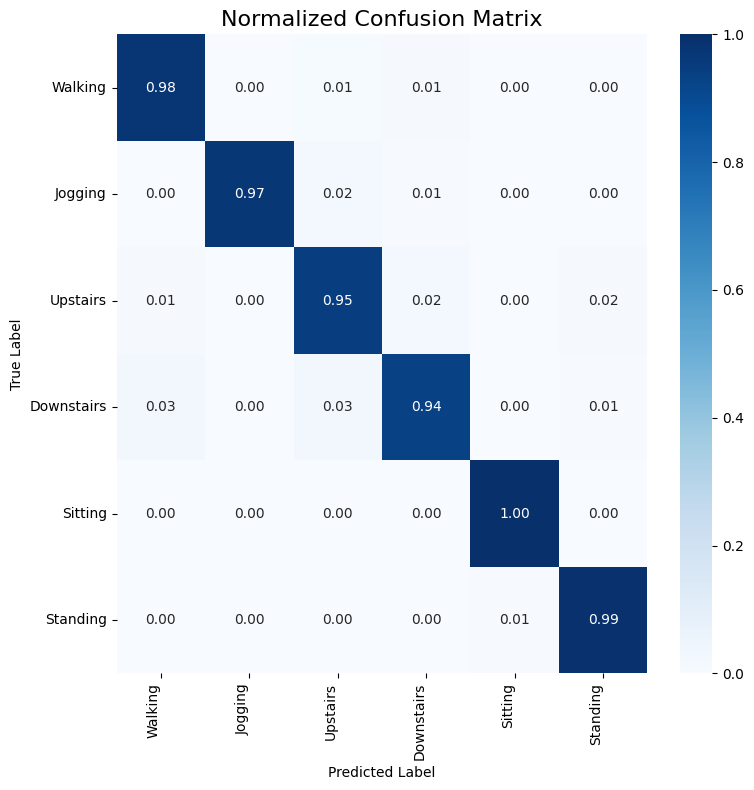


Generating t-SNE visualization (MODEL FEATURE)...


Extracting features for t-SNE: 100%|██████████| 36/36 [00:00<00:00, 62.54it/s]


[Saved] t-SNE (feature space) → tsne_feature.png


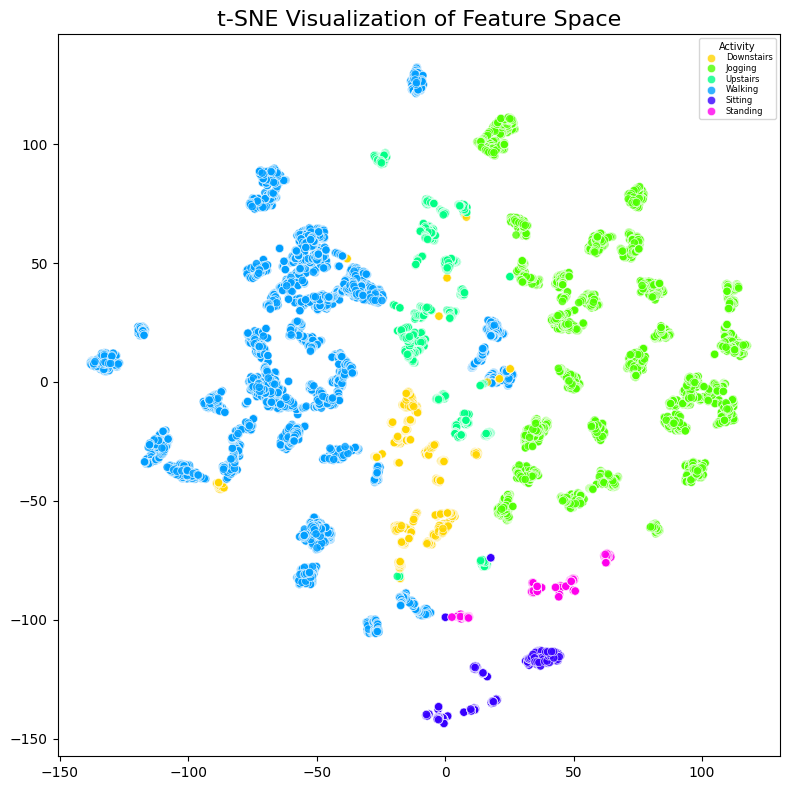


Generating t-SNE visualization (RAW INPUT)...


[Saved] t-SNE (raw input) → tsne_raw.png


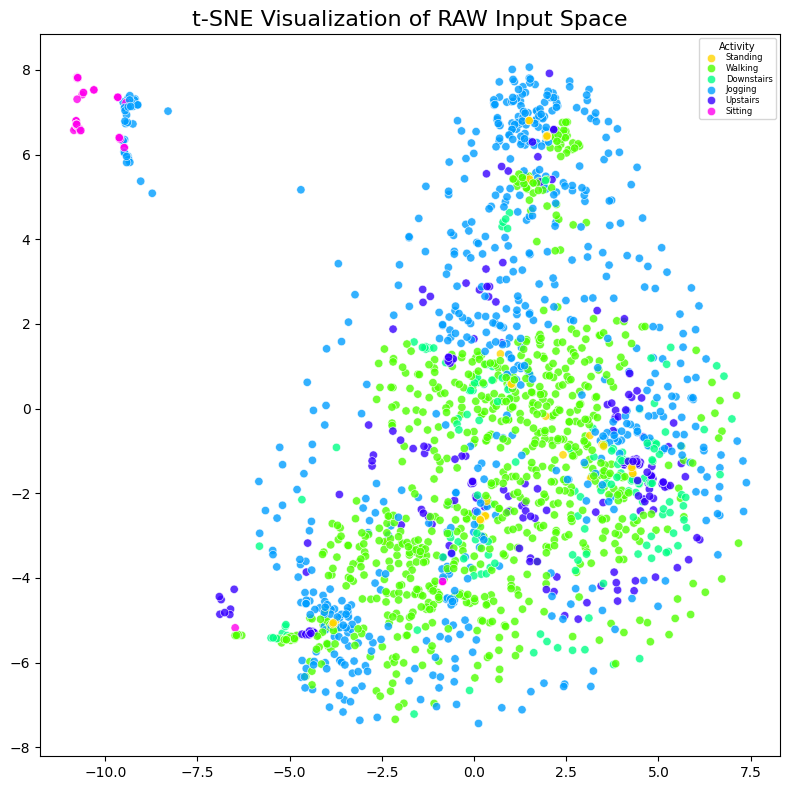

Unsupported operator aten::gelu encountered 3 time(s)
Unsupported operator aten::adaptive_avg_pool1d encountered 2 time(s)
Unsupported operator aten::adaptive_max_pool1d encountered 1 time(s)
Unsupported operator aten::add encountered 4 time(s)
Unsupported operator aten::sigmoid encountered 2 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::mean encountered 1 time(s)
Unsupported operator aten::linalg_vector_norm encountered 1 time(s)
Unsupported operator aten::clamp_min encountered 1 time(s)
Unsupported operator aten::expand_as encountered 1 time(s)
Unsupported operator aten::div encountered 2 time(s)
Unsupported operator aten::unflatten encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::_native_multi_head_attention encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward()

==== Model Profile ====
Parameters      : 0.0672 M
FLOPs / sample : 5.846 M
Infer Time     : 2.43 ms/sample

ALL PROCESSES COMPLETED!


In [12]:
# =====================================================================
# 10. 메인 실행
# =====================================================================
def main():
    # -----------------------------
    # 실험 설정 모음
    # -----------------------------
    config = {
        # 데이터/학습
        'DATA_DIR': 'C://Users/park9/CBAM_HAR/WISDM',
        'BATCH_SIZE': 256,
        'EPOCHS': 100,
        'SEED': 42,
        'LEARNING_RATE': 5e-4,
        'WEIGHT_DECAY': 1e-3,

        # --- 모델 입력 형태 (WISDM용으로 수정) ---
        'in_channels': 3,
        'seq_len': 200,

        # 모델 구조 (너 노트 기준)
        'embed_dim': 64,
        'reduced_dim': 32,
        'n_heads': 8,
        'kernel_size': 13,  # 13
        'dropout': 0.4,  # 0.1

        # 구성 스위치
        'use_cbam': True,
        'use_crossformer': True,
        'use_contrast': True,
        'use_dim_reduction': False,

        # Loss 관련
        'temperature': 0.05,
        'contrast_weight': 0.1,
    }

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seed_everything(config['SEED'])

    print(f"Device: {DEVICE}")
    print(f"Loading UCI HAR Dataset from: {config['DATA_DIR']}")

    # -----------------------------
    # 1. 데이터셋 전체 로드
    # -----------------------------
    full_df = load_full_dataframe(os.path.join(config['DATA_DIR'], 'WISDM_ar_v1.1_raw.txt'))
    
    # -----------------------------
    # 2. 랜덤 분할 (subject-wise 끄기)
    # -----------------------------
    # 1) split 완료 (랜덤 split로 subject-wise 깨버린 상태)
    trainval_df, test_df = train_test_split(
        full_df,
        test_size=0.2,
        shuffle=True,
        random_state=config['SEED']
    )

    train_df, val_df = train_test_split(
        trainval_df,
        test_size=0.2,
        shuffle=True,
        random_state=config['SEED']
    )

    print("Split sizes (rows):", len(train_df), len(val_df), len(test_df))

    # 2) 표준화
    feature_columns = ['x', 'y', 'z']
    scaler = StandardScaler()
    scaler.fit(train_df[feature_columns])  # train에서만 fit

    train_df[feature_columns] = scaler.transform(train_df[feature_columns])
    val_df[feature_columns]   = scaler.transform(val_df[feature_columns])
    test_df[feature_columns]  = scaler.transform(test_df[feature_columns])

    # 3) oversampling으로 train_df를 키워서 balance 맞추기
    train_df_bal = oversample_to_max_count(train_df, activity_col='activity', seed=config['SEED'])

    print("Class counts (train before):", train_df['activity'].value_counts().to_dict())
    print("Class counts (train after ):",  train_df_bal['activity'].value_counts().to_dict())
    print("val dist:",  val_df['activity'].value_counts().to_dict())
    print("test dist:", test_df['activity'].value_counts().to_dict())
    
    # -----------------------------
    # 4. 각 DataFrame으로 Dataset 객체 생성
    # -----------------------------
    train_dataset = WISDMDataset(train_df_bal, window_size=config['seq_len'])
    val_dataset = WISDMDataset(val_df, window_size=config['seq_len'])
    test_dataset = WISDMDataset(test_df, window_size=config['seq_len'])

    print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

    g = torch.Generator().manual_seed(config['SEED'])

    train_loader = DataLoader(
        train_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=True,
        num_workers=0,
        drop_last=False,
        worker_init_fn=seed_worker,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=False,
        num_workers=0,
        drop_last=False,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=False,
        num_workers=0,
        drop_last=False,
        worker_init_fn=seed_worker,
        generator=g
    )


    # -----------------------------
    # 프로토타입 초기화
    # -----------------------------
    initial_prototypes = get_mean_prototypes(train_dataset, DEVICE, config)

    print("\n" + "="*80)
    print(f"Training with config: {config}")
    print("="*80)

    # -----------------------------
    # 모델 생성
    # -----------------------------
    model = ContrastCrossFormerCBAM_HAR(
        in_channels=config['in_channels'],
        seq_len=config['seq_len'],
        n_classes=6,
        n_prototypes=6,
        embed_dim=config['embed_dim'],
        reduced_dim=config['reduced_dim'],
        n_heads=config['n_heads'],
        kernel_size=config['kernel_size'],
        dropout=config['dropout'],
        temperature=config['temperature'],
        initial_prototypes=initial_prototypes,
        use_cbam=config['use_cbam'],
        use_crossformer=config['use_crossformer'],
        use_contrast=config['use_contrast'],
        use_dim_reduction=config['use_dim_reduction']
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")

    # -----------------------------
    # optimizer / scheduler / criterion
    # -----------------------------
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['LEARNING_RATE'],
        weight_decay=config['WEIGHT_DECAY']
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['EPOCHS']
    )

    # -----------------------------
    # 학습 루프
    # -----------------------------
    history = []
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None

    for epoch in range(config['EPOCHS']):
        train_results = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            DEVICE,
            use_contrast=config['use_contrast'],
            contrast_weight=config['contrast_weight']
        )
        val_results = evaluate(model, val_loader, criterion, DEVICE)
        scheduler.step()

        train_loss, train_ce, train_contrast, train_acc, train_f1 = train_results
        val_loss, val_acc, val_f1, _, _ = val_results

        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
        })

        # best ckpt 추적
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1:03d}/{config['EPOCHS']:03d}] "
                f"TrainLoss={train_loss:.4f} "
                f"TrainAcc={train_acc:.4f} "
                f"ValAcc={val_acc:.4f}"
            )

    # -----------------------------
    # 최종 테스트 (best 상태로)
    # -----------------------------
    assert best_state is not None, "best_state is None (no epochs?)"
    model.load_state_dict(best_state)

    test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
        model, test_loader, criterion, DEVICE
    )

    print(f"\n✓ Training Complete!")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(f"  Final Test (Best-VAL ckpt): Acc={test_acc:.4f} | F1={test_f1:.4f}")

    # -----------------------------
    # 시각화 + 저장
    # -----------------------------
    plot_classification_results(
        test_labels,
        test_preds,
        save_path="confusion_matrix.png"
    )

    visualize_tsne(
        model,
        test_loader,
        DEVICE,
        save_path="tsne_feature.png"
    )

    visualize_tsne_raw(
        test_loader,
        DEVICE,
        save_path="tsne_raw.png"
    )

    # -----------------------------
    # 모델 프로파일링
    # -----------------------------
    dummy_input = torch.randn(1, 3, config['seq_len'])  # (B=1, C=3, T=128)
    stats = profile_model(model, dummy_input, DEVICE)
    print_model_profile(stats)

    print("\n" + "="*80)
    print("ALL PROCESSES COMPLETED!")
    print("="*80)


if __name__ == "__main__":
    main()